# Test of Ansaetze with structure. 

VQD runs without shot noise

In [1]:
import qiskit

In [2]:
qiskit.__version__

'0.25.1'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir
from itertools import permutations,product
from tqdm.notebook import tqdm
import datetime

In [5]:
from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz
import primme

/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_1085/2428390827.py:5: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


In [464]:
from Observables import *

In [71]:
#Qiskit import
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf
from qiskit.primitives import Sampler, Estimator
#from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from sys import stdout
from qiskit_algorithms.optimizers import NFT,SLSQP,COBYLA,ADAM,SPSA,QNSPSA,CG,GradientDescent
from qiskit.quantum_info.states import DensityMatrix
import qiskit.quantum_info as qinf
from qiskit.quantum_info import entropy
from qiskit_algorithms.eigensolvers import VQD
from qiskit_algorithms.minimum_eigensolvers import VQE


In [7]:
from qiskit_ibm_provider import IBMProvider

In [9]:
from qiskit_ibm_provider import IBMProvider
# Load a previously saved account.
provider = IBMProvider(instance='ibm-q-desy/internal/simulators')

In [41]:
backend = provider.get_backend("ibmq_qasm_simulator")

In [42]:
#runtime
# # The IBM Qiskit Runtime
# from qiskit_ibm_runtime import QiskitRuntimeService
# from qiskit_ibm_runtime import Estimator, Session
# service = QiskitRuntimeService(
# 	channel='ibm_quantum',instance='ibm-q-desy/internal/simulators')
# backend = service.get_backend("ibmq_qasm_simulator");backend

<IBMBackend('ibmq_qasm_simulator')>

In [43]:
# from qiskit_ibm_runtime import Options,Sampler

##### Functions

In [93]:
def fidelity_func(myvqd_results2,eigenvectors_matrix,num_eigs):

    """ Inputs; results from VQD and eigenvector matrix from ED. Update to Qiskit version 0.24.1"""
    
    vqd_states = [myvqd_results2.optimal_circuits[i].bind_parameters(myvqd_results2.optimal_parameters[i].values()) for i in range(num_eigs)]

    vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]

    return [qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)]

In [94]:
def fidelity_func_e(vqd,ed,index_ed,index_vqd):

    """ Inputs; results from VQD and eigenvector matrix from ED. Update to Qiskit version 0.24.1"""
    
    vqd_states = vqd.optimal_circuits[index_vqd].bind_parameters(vqd.optimal_parameters[index_vqd].values())

    vqd_fid_states =qinf.Statevector.from_instruction(vqd_states)
    ed_fid_states =Statevector(ed[:,index_ed]) 

    return qinf.state_fidelity(vqd_fid_states,ed_fid_states)

##### Hamiltonian

In [668]:
#class input parameters:
n_sites = [2,2]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=-2
omega=1
l=1
L=4
rotors = False
lambd = 1000
encoding = 'gray' ##'ed'#
magnetic_basis=False
pbc=True
puregauge = True 
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 
sparse_pauli =False #false for circuit ansatz
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 2

In [669]:
latt = HCLattice(n_sites,pbc=pbc)

In [670]:
hamilt_sym = HamiltonianQED_sym(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian)

class_H_oprt = HamiltonianQED_oprt(
                        latt,
                        hamilt_sym,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        sparse_pauli=sparse_pauli)

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.009538650512695312 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
>> Hamiltonian built.  Execution time: 10.590226888656616 seconds
>> Suppression term built.  Execution time: 0.0033540725708007812 seconds


##### Lattice system

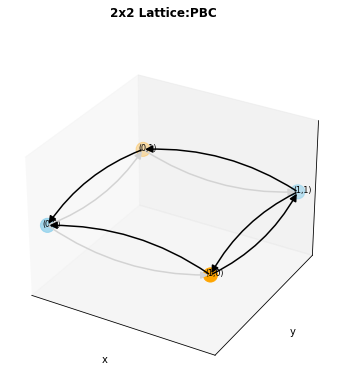

In [671]:

#latt.draw_graph_func(gauss_law_fig=False,static_charges=static_charges_values)
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free)#,savefig_dir='.')

In [672]:
class_H_oprt.qop_list[::-1]+class_H_oprt.uop_list[::-1]#order of operators in tensor product and on circuit little endian ..q2q1q0

[U_01y, U_10x, U_11x, U_10y, U_11y]

In [673]:
for i,k in enumerate(class_H_oprt.uop_list+class_H_oprt.phiop_list):
    print(f'qubit{i}:{k}') 

print('or charges')
for i,k in enumerate(class_H_oprt.uop_list+class_H_oprt.qop_list):
    print(f'qubit{i}:{k}') 

qubit0:U_11y
qubit1:U_10y
qubit2:U_11x
qubit3:U_10x
qubit4:U_01y
qubit5:Phi_1
qubit6:Phi_2
qubit7:Phi_3
qubit8:Phi_4
or charges
qubit0:U_11y
qubit1:U_10y
qubit2:U_11x
qubit3:U_10x
qubit4:U_01y


##### Fermionic circuit

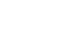

In [237]:
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)#TODO add fermionic part


ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f)

qferm = QuantumRegister(n_qubits_f,name='ferm')
qc_tot2 = QuantumCircuit(qferm)

qc_tot2.compose(ansatz_class.qc_ferm,qferm,inplace=True)

qc_tot2.draw('mpl')

##### Puregauge circuit

In [675]:
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f)

qgaug = QuantumRegister(n_qubits*ngauge,name='gaug')
qc_tot2 = QuantumCircuit(qgaug)

qc_tot2.compose(ansatz_class.qc_gauge,qgaug,inplace=True)

th = ansatz_class.th_gauge+1
for k in range(n_qubits*ngauge):
    qc_tot2.rz(Parameter(f'theta_{th}'), k)
    th+=1
#print('Total depth',qc_tot2.depth())    
print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose().count_ops())['cx'])
#qc_tot2.draw('mpl')


Total n.er of CNOT gates (Toffoli are decomposed): 290


##### Composite circuit: gauge + fermions

In [17]:
# #ansatz pure gauge no entanglement
# nlayers = 1#TODO ATTENTION: selection of only physical states work only for nlayers=1
# ngauge = class_H_oprt.len_e_op
# nsites = 0#TODO add fermionic part
# n_qubits =int(np.ceil(np.log2(2 * l+ 1)))
# qc_tot = QuantumCircuit(n_qubits*ngauge+nsites)


# th=0
# #first gauge field
# qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
# qc_tot.compose(qcc,list(range(n_qubits)),inplace=True)

# for i in range(1,ngauge):#for the other gauge fields
#     theta = int(''.join(list(filter(str.isdigit, str(lst[-1])))))
#     qcc,lst = gray_code_lim(l,theta=theta+1,layers=nlayers)
#     qc_tot.compose(qcc,list(range(n_qubits*i,n_qubits*(i+1))),inplace=True)

# th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))+1
# qc_tot.barrier()

# #**entanglement**
# #between the gauge fields
# # for i in range(n_qubits):
# #     for j in range(n_qubits,n_qubits*ngauge):
# #         qc_tot.cx(i,j)

# #linear entanglement cx gates
# # for i in range(n_qubits*ngauge-1):
# #     qc_tot.cx(i,i+1)


# #full entanglement cx gates
# # for i in range(n_qubits*ngauge):
# #     for j in range(i+1,n_qubits*ngauge):
# #         qc_tot.cx(i,j)

# #qc_tot.draw('mpl')#,filename='gray_code_lim_l1.png')

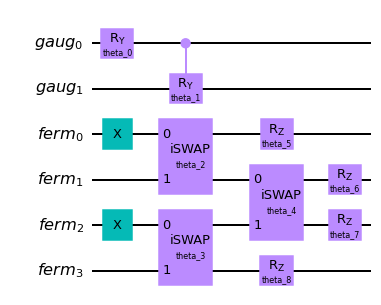

In [60]:
#ansatz full entanglement
nlayers = 1#TODO option more layers?
nlayers_f = 1
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)#TODO add fermionic part

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

qferm = QuantumRegister(n_qubits_f,name='ferm')
qgaug = QuantumRegister(n_qubits*ngauge,name='gaug')
qc_tot2 = QuantumCircuit(qgaug,qferm)

th=0
#gauge part
if ngauge:
    qcc,lst = gray_code_lim(l,theta=th,layers=nlayers)
    #first gauge field
    qc_tot2.compose(qcc,list(range(n_qubits)),inplace=True)
    # qc_tot2.barrier()
    th=int(''.join(list(filter(str.isdigit, str(lst[-1])))))+1

    for i in range(1,ngauge):
        qc_tot2.ry(Parameter(f'theta_{th}'),n_qubits*i)
        th+=1
        for j in range(n_qubits*i):
            qc_tot2.cry(Parameter(f'theta_{th}'),j,n_qubits*i)
            th+=1
        # qc_tot2.barrier()
        qc_tot2.cry(Parameter(f'theta_{th}'),n_qubits*i,n_qubits*i+1)
        th+=1
        # qc_tot2.barrier()
        #multi-controlled gates
        for j in range(n_qubits*i):
            qc_tot2.mcry(Parameter(f'theta_{th}'),[j,n_qubits*i],n_qubits*i+1)
            th+=1

#fermion circuit proposal
p = Parameter('p')
qc = QuantumCircuit(2,name='iSWAP')
qc.rxx(p, 0, 1)
qc.ryy(p, 0, 1)


params = lambda i: Parameter(f'theta_{i}')

#th=0

for i in range(0,n_qubits_f,2):
    qc_tot2.x(qferm[i])
for nl in range(nlayers_f):
    for j in range(n_qubits_f//2):
        for i in range(j,n_qubits_f-j,2):
            qc_tot2.append(qc.to_instruction({p: params(th)}), qferm[i:i+2])
            th+=1

#last layer of Rz gates for correct phase
# for i in range(ngauge*n_qubits):
#     qc_tot2.rz(Parameter(f'theta_{th}'),i)
#     th+=1
for i in range(n_qubits_f):
    qc_tot2.rz(Parameter(f'theta_{th}'),qferm[i])
    th+=1
    
qc_tot2.draw('mpl')#,filename='gray_code_lim_l1.png')
#qc_tot2.decompose().draw('mpl')

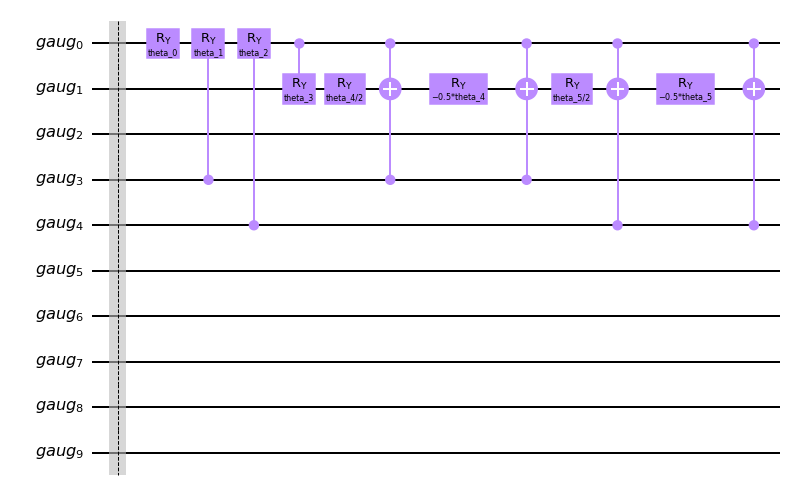

In [323]:
#ansatz entanglement
nlayers = 1#TODO option more layers?
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)#TODO add fermionic part

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

qferm = QuantumRegister(n_qubits_f,name='ferm')
qgaug = QuantumRegister(n_qubits*ngauge,name='gaug')
qc_tot2 = QuantumCircuit(qgaug,qferm)

th=0
qc_tot2.barrier()
#fermion circuit proposal
p = Parameter('p')
qc = QuantumCircuit(2,name='iSWAP')
qc.rxx(p, 0, 1)
qc.ryy(p, 0, 1)
#qc.rzz(p, 0, 1)#TODO: only for NFT optimizer
params = lambda i: Parameter(f'theta_{i}')

#th=0
for i in range(1,n_qubits_f,2):
    qc_tot2.x(qferm[i])

for j in range(n_qubits_f//2):
    for i in range(j,n_qubits_f-j,2):
            qc_tot2.append(qc.to_instruction({p: params(th)}), qferm[i:i+2])
            th+=1

#gauge part
qc_tot2.ry(Parameter(f'theta_{th}'),0)
th+=1
#entangling with fermions 1st option
# for j in range(2,6):
#     qc_tot2.cry(Parameter(f'theta_{th}'),j,0)
#     th+=1
# for j in range(2,6):
#     qc_tot2.mcry(Parameter(f'theta_{th}'),[0,j],1)
#     th+=1

#entangling with fermions 2nd option
qc_tot2.cry(Parameter(f'theta_{th}'),3,0)
th+=1
qc_tot2.cry(Parameter(f'theta_{th}'),4,0)
th+=1


qc_tot2.cry(Parameter(f'theta_{th}'),0,1)
th+=1

qc_tot2.mcry(Parameter(f'theta_{th}'),[0,3],1)
th+=1
qc_tot2.mcry(Parameter(f'theta_{th}'),[0,4],1)
th+=1

# for i in range(ngauge*n_qubits):
#     qc_tot2.rz(Parameter(f'theta_{th}'),i)
#     th+=1

for i in range(n_qubits_f):
    qc_tot2.rz(Parameter(f'theta_{th}'),qferm[i])
    th+=1

qc_tot2.draw('mpl')#,filename='gray_code_lim_l1.png')
#qc_tot2.decompose().draw('mpl')

In [22]:
qc_tot2.depth()

15

##### ED

In [676]:
#ED
import scipy.sparse as sp
Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
#memory sparse matrix
#print((Hamiltonian_Pauli_tot.data.nbytes + Hamiltonian_Pauli_tot.indptr.nbytes + Hamiltonian_Pauli_tot.indices.nbytes)/1000**3,'Gb')
if encoding=='gray' and not sparse_pauli:
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
    if ngauge:
        h_b_sparse = class_H_oprt.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
    else:
        h_b_sparse = 0 
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
    if ngauge:
        h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
    else:
        h_b_sparse =0

#** Exact diagonalisation
spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
#spectrum
idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]

# ed_val = []
# for kk in range(num_eigs):
#     ed_val.append(dict([(str(np.binary_repr(i, width = (ngauge*n_qubits+n_qubits_f))),np.abs(eigenvectors_matrix[:,kk][i])**2) for i in range(2**(ngauge*n_qubits+n_qubits_f)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-10]))

eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()
eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
if ngauge:
    plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real
    #same as: ((eig0cj.toarray()[:,0]).dot((h_b_sparse).dot((eig0.toarray()[0,:]))).real)/len(latt.plaq_list)
print('spectrum ED:',spectrum,'plaq',plaq)
#***** total charge
if not puregauge:
    tot_charge_op = total_charge_op(latt,class_H_oprt, puregauge,encoding).to_matrix(sparse=True) if encoding=='gray' else total_charge_op(latt,class_H_oprt, puregauge,encoding)
    tot_charge  =  (eig0*tot_charge_op*eig0cj).toarray()[0][0].real
    print('total charge <GS|Q|GS>:',np.round(tot_charge,8))
    particle_n_op = particle_density(latt,class_H_oprt, puregauge,encoding).to_matrix(sparse=True) if encoding=='gray' else particle_density(latt,class_H_oprt, puregauge,encoding)
    particle_n =  (eig0*particle_n_op*eig0cj/(np.prod(n_sites))).toarray()[0][0].real
    print('particle_density:',particle_n)

spectrum ED: [-1.0066823  -0.26964819] plaq 0.46234511306441434


In [130]:
#plot_histogram(ed_val[0])#TODO: physical interpretation of the states?

##### Input parameteres circuit

In [507]:
from time import perf_counter

In [677]:
#Input parameters for VQD

estimator = Estimator()
estimator.set_options(shots=1024,backend=backend)
print(estimator.options)
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

aux_operators =[class_H_oprt.hamiltonian_mag_pauli,] if ngauge else None
Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)


iterations = [500 for i in range(num_eigs)]
optimizer = [COBYLA(maxiter=itr) for itr in iterations] #SLSQP,COBYLA  #TODO: with NFT iSWAPS with also Rzz gates
ansatz = qc_tot2
betas = [2,]*(num_eigs-1)  #***default value computed as the mean square sum of the coefficients of the observable.

#*** initial point
val_init = np.pi/4
#initial_point=[val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) for kkk in range(num_eigs)]
initial_point=val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) 

#previous best
#initial_point = [np.array(list(result.optimal_parameters[0].values())),]+[val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) for kkk in range(num_eigs-1)]

#predefined initial point vacuum
#initial_point = {pa: np.pi if str(pa) in ('theta_3') else float(val_init*(2*np.random.rand(1))) for pa in ansatz.parameters}
# initial_dict={pa: np.pi if str(pa) in ('theta_3', 'theta_4') else float(val_init*(2*np.random.rand(1))) for pa in ansatz.parameters}

# indices = [int(str(param).split('_')[1]) for param in initial_dict.keys()]
# for i,el in enumerate(indices):
#     if el==3:
#         indices[i]=np.pi
#     else:
#         indices[i]=float(val_init*(2*np.random.rand(1)))
# initial_point= np.array(indices)

Options(shots=1024, backend=<IBMBackend('ibmq_qasm_simulator')>)


In [663]:
# from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options#TODO runtime estimator does not work
# options = Options()
# options.optimization_level = 0 # No optimization, optimization_level=3 adds dynamical decoupling
# options.execution.shots = 1024
# options.resilience_level = 1 #1: T-Rex / 2: ZNE/ 3: PEC readout error mitigation
# options.simulator={'noise_model':None}#noise_model}
# options.transpilation.skip_transpilation = False
# #options = Options(optimization_level=0, resilience_level=0)#,simulator={'noise_model':noise_model}) #noise model

# #callback function
# E_data = [[] for k in range(num_eigs)]
# Fidelity = [[] for k in range(num_eigs)]
# def callback(eval_count, parameters, mean, meta, step):
#     stdout.write("eig: %d/%d -> its %4d \r"%(step,num_eigs,eval_count)) # assuming SPSA
#     stdout.flush()

#     #fidelity
#     vqd_states = [ansatz.bind_parameters(parameters) for i in range(num_eigs)]
#     vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
#     ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
#     Fidelity[step-1].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])

#     #energy
#     E_data[step-1].append([len(E_data[step-1]),mean,meta])
    
# with Session(service=service, backend=backend,max_time='2h') as session:
#     estimator = Estimator(session=session,options=options)
#     sampler = Sampler(session=session,options=options )
#     fidelity = ComputeUncompute(sampler)

#     print(estimator.options)
#         # run VQD
#     from qiskit.algorithms.eigensolvers import VQD #or myvqd for VQD with extensions
    
#     start_time = perf_counter()
#     #Perform VQD for Hamiltonian and plaquette operator
#     vqd = VQD(estimator, fidelity, ansatz, optimizer, k=num_eigs, betas=betas,initial_point=initial_point,  callback=callback)
#     result = vqd.compute_eigenvalues(operator = Hamiltonian_Pauli_tot_vqd,aux_operators = aux_operators)# Hamiltonian + auxiliary operator
#     end_time = perf_counter()

#     #session_id = session.session_id()
#     #print([service.runtime.jobs(session_id=session_id)[i].result() for i in range(len(service.runtime.jobs(session_id=session_id)))])
#     session.close()
#     print('time computation',end_time-start_time)
#     print(result.eigenvalues[0].real)
#     time_cost_func_evals = [result.optimizer_times[i]/result.cost_function_evals[i]+1 for i in range(num_eigs)]
#     print(f'Time for each cost function evaluation (tot evaluations={result.cost_function_evals}):',[f'E_{k}:s {time_cost_func_evals[k]} ' for k in range(num_eigs)] )
    

### VQD

In [664]:
#with shotnoise
#callback function on file
def callback_file(eval_count, parameters, mean, meta, step):

    stdout.write("eig: %d/%d -> its %4d \r"%(step,num_eigs,eval_count)) # assuming SPSA
    stdout.flush()
    #write on file every 10 evaluations
    if eval_count%10==0:
        with open('output.txt', 'a') as f:
            f.write(str(step)+','+str(eval_count)+','+str(mean)+','+str(parameters)+'\n')

#callback function
E_data = [[] for k in range(num_eigs)]
Fidelity = [[] for k in range(num_eigs)]
def callback(eval_count, parameters, mean, meta, step):
    now = datetime.datetime.now()
    # stdout.write("eig: %d/%d -> its %4d \r"%(step,num_eigs,eval_count)) # assuming SPSA
    # stdout.flush()

    #fidelity
    vqd_states = [ansatz.bind_parameters(parameters) for i in range(num_eigs)]
    vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
    ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
    Fidelity[step-1].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])
    #energy
    E_data[step-1].append([len(E_data[step-1]),mean,meta])
    if not len(E_data[step-1])%10:
        print(now, "*** step" ,f'E_{step-1} data:',E_data[step-1][-1],'Fid.:',Fidelity[step-1][-1], "\n",flush=True)


start_time = perf_counter()
#Perform VQD for Hamiltonian and plaquette operator
vqd = VQD(estimator, fidelity, ansatz, optimizer, k=num_eigs, betas=betas,initial_point=initial_point,  callback=callback)
result = vqd.compute_eigenvalues(operator = Hamiltonian_Pauli_tot_vqd,aux_operators = aux_operators)# Hamiltonian + auxiliary operator
vqd_values = result.eigenvalues
end_time = perf_counter()

print('time computation',end_time-start_time)
print(result.eigenvalues)
time_cost_func_evals = [result.optimizer_times[i]/result.cost_function_evals[i]+1 for i in range(num_eigs)]
print(f'Time for each cost function evaluation (tot evaluations={result.cost_function_evals}):',[f'E_{k}:s {time_cost_func_evals[k]} ' for k in range(num_eigs)] )

#eigenvectors
vqd2_eigenstates = []
for i in range(num_eigs):
    tmp = result.optimal_circuits[i].copy()
    
    tmp.measure_all()
    opt_pt =list(result.optimal_parameters[i].values())
    res = sampler.run(tmp, opt_pt).result() 
    
    vqd2_eigenstates.append({x:round(y,6) for x,y in res.quasi_dists[0].binary_probabilities().items() if y>0.0001})
    tmp.remove_final_measurements()

if ngauge:
    plaq_vqd = np.array(result.aux_operators_evaluated[0])[:,0][0]/len(latt.plaq_list)

2023-10-01 20:16:00.970218 *** step E_0 data: [9, 6.8359927982774105, {'variance': 5.11201696158345, 'shots': 1024}] Fid.: [0.00855359377594564, 0.018452053277392293] 

2023-10-01 20:16:01.629845 *** step E_0 data: [19, 1.8957357607092635, {'variance': 1.7952856919272793, 'shots': 1024}] Fid.: [0.06648489677660706, 0.44893570059395965] 

2023-10-01 20:16:02.246016 *** step E_0 data: [29, 0.3948792577710942, {'variance': 3.186506911222038, 'shots': 1024}] Fid.: [0.7893009395071061, 0.002314205028887865] 

2023-10-01 20:16:02.867418 *** step E_0 data: [39, 0.32958571706924494, {'variance': 1.7459144078325952, 'shots': 1024}] Fid.: [0.6879101821139332, 0.08820233268187727] 

2023-10-01 20:16:03.515731 *** step E_0 data: [49, 0.2862576192373709, {'variance': 1.334232415350573, 'shots': 1024}] Fid.: [0.6989560439316906, 0.0928805511878215] 

2023-10-01 20:16:04.148055 *** step E_0 data: [59, 0.2234884092256322, {'variance': 1.3375822303981677, 'shots': 1024}] Fid.: [0.7200488913324999, 0.08

In [665]:
print(f'E_i ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}iterations{iterations} optimizer'+
[i for i in ['NFT','SLSQP','COBYLA','ADAM','SPSA','GradientDescent'] if i in str(optimizer[0])][0])

#** Print results
for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
            print(f'E_{kk}(ED)=',round(evalu,8))#,[(str(np.binary_repr(i, width = (ngauge*n_qubits))),round(np.abs(eigenvectors_matrix[:,kk][i])**2,6)) for i in range(2**(ngauge*n_qubits)) if np.abs(eigenvectors_matrix[:,kk][i])**2>1e-4])
            print(f'E_{kk}(VQD)=',vqd_values.real[kk])#,vqd2_eigenstates[kk])

#** Plaquette operator
print('\n','Plaq. ED:',plaq,'Plaq. VQD:',plaq_vqd.real,'\n')

# #** Fidelity final
fid=fidelity_func(result,eigenvectors_matrix,num_eigs)
print('Fidelity (|psi_VQDXpsi_ED|^2):')
[print(f'E_{i}:',fd) for i,fd in enumerate(fid)]


#**Check if there are unphysical states
gray_unph = []
for i in range(2 * l + 1, 2**int(np.ceil(np.log2(2 * l+ 1)))):
    gray_decimal = i ^ (i >> 1)
    gray_unph.append("{0:0{1}b}".format(gray_decimal,int(np.ceil(np.log2(2 * l+ 1)))))  

ferm_q0 = [''.join(i) for i in permutations(['0','1']*(n_qubits//2),n_qubits)]

print('Check if in VQD sol. there are unphysical states: Gauge fields:',gray_unph,'Fermions: only zero charge are considered physical')
for i in range(num_eigs):
    if ngauge:
        for vqd_res in [string[-(ngauge*n_qubits):][i:i+int(np.ceil(np.log2(2 * l+ 1)))] for string in vqd2_eigenstates[i].keys() for i in range(0, len(string[-(ngauge*n_qubits):]), int(np.ceil(np.log2(2 * l+ 1))))]:
            if vqd_res in gray_unph:
                print('unphysical state reached for gauge fields')
                break
        else:   
            print(f'E_{i} all physical states reached gauge fields: OK!')
    if n_qubits_f:
        for vqd_res in [string[:n_qubits_f] for string in vqd2_eigenstates[i].keys() ]:

            if vqd_res in ferm_q0:
                print('unphysical state reached for fermions')
                break
        else:   
            print(f'E_{i} all physical states reached fermions: OK!')


E_i ED vs VQD test:2D_3x2mbasisFalse puregaugeTrue g1 pbcFalse l1_factE1_factB1_m-2_Omega1iterations[500, 500] optimizerCOBYLA
E_0(ED)= -0.43669289
E_0(VQD)= 0.2384949121549415
E_1(ED)= 1.62553669
E_1(VQD)= 1.599927936663542

 Plaq. ED: 0.38777667818947165 Plaq. VQD: 0.18373636685790357 

Fidelity (|psi_VQDXpsi_ED|^2):
E_0: 0.7232710546937338
E_1: 0.0155629431144224
Check if in VQD sol. there are unphysical states: Gauge fields: ['10'] Fermions: only zero charge are considered physical
E_0 all physical states reached gauge fields: OK!
E_1 all physical states reached gauge fields: OK!


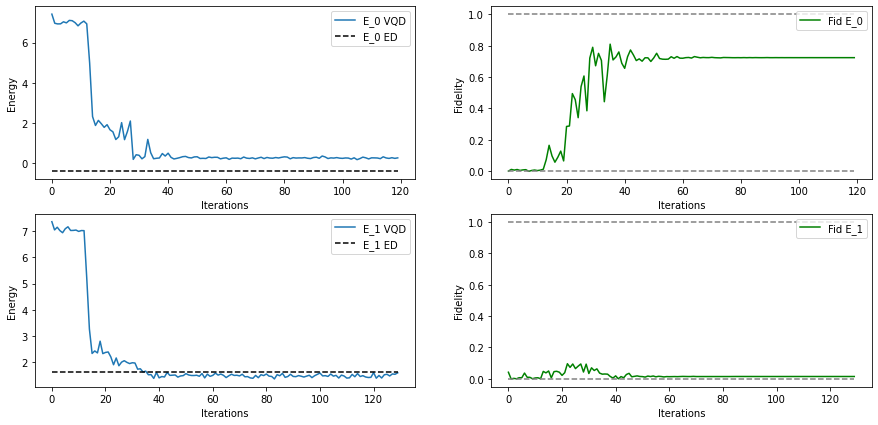

In [666]:

fig,axes = plt.subplots(num_eigs,2,figsize=(15,7))

for k in range(num_eigs):
    #Energy
    axes[k][0].plot([i[0] for i in E_data[k]],[i[1] for i in E_data[k]],label=f'E_{k} VQD')
    axes[k][0].hlines(spectrum[k],0,E_data[k][-1][0],linestyles='dashed',color='black',label=f'E_{k} ED')

    #Fidelity
    axes[k][1].plot([i[0] for i in E_data[k]],[i[k] for i in Fidelity[k]],label=f'Fid E_{k}',color='green')
    #fidelity max value 1 and min 0
    axes[k][1].hlines(1,0,E_data[k][-1][0],linestyles='dashed',color='gray')
    axes[k][1].hlines(0,0,E_data[k][-1][0],linestyles='dashed',color='gray')

    axes[k][0].set_ylabel('Energy')
    axes[k][1].set_ylabel('Fidelity')

    for i in range(2):
        axes[k][i].set_xlabel('Iterations')
        axes[k][i].legend()

#fig.savefig('ansatz_tests/'+f'Energy_Fidelity_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}.png')

##### Fidelity 

spectrum ED:
['E_0=-1.00668', 'E_1=-0.26965', 'E_2=-0.26965', 'E_3=-0.20739', 'E_4=-0.20739', 'E_5=0.4421', 'E_6=0.4421', 'E_7=0.4421', 'E_8=0.4421', 'E_9=0.81453', 'E_10=0.82548', 'E_11=0.82548', 'E_12=0.91429', 'E_13=0.91877', 'E_14=0.91877', 'E_15=1.04591', 'E_16=1.31935', 'E_17=1.31935', 'E_18=1.35503', 'E_19=1.35503']


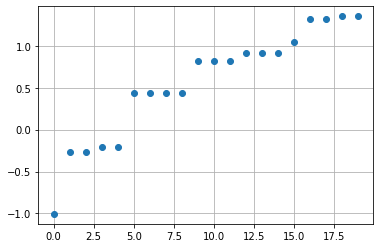

In [235]:
spectrum_fid, eigenvectors_matrix_fid =primme.eigsh(Hamiltonian_Pauli_tot,k=20,which="SA")#,ncv = 30)
#spectrum_fid
idx = spectrum_fid.argsort() 
spectrum_fid = spectrum_fid[idx]
eigenvectors_matrix_fid = eigenvectors_matrix_fid[:,idx]
print(f'spectrum ED:')
print([f'E_{n}={np.round(i,5)}' for n,i in enumerate(spectrum_fid)])
plt.plot(spectrum_fid,'o',label='ED')
plt.grid()

In [238]:
print('fidelity overlap of ground state with up to 8th excited states')
[print(f'E_{i}: val={np.round(spectrum_fid[i],6)}, fidelity: {np.round(fidelity_func_e(result,eigenvectors_matrix_fid,i,0),5)}') for i in range(1,9)]
print('fidelity overlap of 1st excited state with up to 8th excited states')
[print(f'E_{i}: val={np.round(spectrum_fid[i],6)}, fidelity: {np.round(fidelity_func_e(result,eigenvectors_matrix_fid,i,1),5)}') for i in range(1,9)]
print('\n sum of fid.: ',sum([fidelity_func_e(result,eigenvectors_matrix_fid,i,1) for i in range(1,9)]))

fidelity overlap of ground state with up to 8th excited states
E_1: val=-0.269648, fidelity: 5.7e-08
E_2: val=-0.269648, fidelity: 3.92e-08
E_3: val=-0.207391, fidelity: 4.2e-09
E_4: val=-0.207391, fidelity: 2e-10
E_5: val=0.442095, fidelity: 0.0
E_6: val=0.442095, fidelity: 1e-10
E_7: val=0.442095, fidelity: 3e-10
E_8: val=0.442095, fidelity: 0.0
E_9: val=0.814527, fidelity: 2.5691e-06
E_10: val=0.825481, fidelity: 3.4e-09
E_11: val=0.825481, fidelity: 8.5e-09
E_12: val=0.914286, fidelity: 7.298e-07
E_13: val=0.918771, fidelity: 1.3e-09
E_14: val=0.918771, fidelity: 1.7e-09
E_15: val=1.045911, fidelity: 0.0006460399
E_16: val=1.319349, fidelity: 4.5e-09
E_17: val=1.319349, fidelity: 1e-09
E_18: val=1.355027, fidelity: 3e-10
fidelity overlap of 1st excited state with up to 8th excited states


Overlap with other states

Text(0.5, 0.98, 'Fidelity overlap of kth excited state with 1-8th excited states')

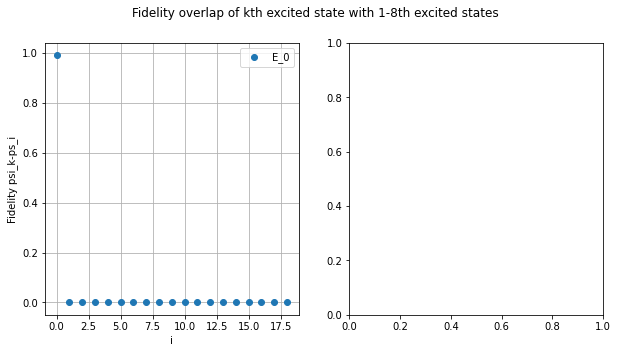

In [237]:
fig,ax = plt.subplots(1,num_eigs,figsize=(10,5))

for k in range(num_eigs):
    ax[k].plot([fidelity_func_e(result,eigenvectors_matrix_fid,i,k) for i in range(9)],'o',label=f'E_{k}')

    ax[k].grid()
    ax[k].legend()
    ax[k].set_xlabel('i')
    ax[k].set_ylabel('Fidelity psi_k-ps_i')

fig.suptitle('Fidelity overlap of kth excited state with 1-8th excited states')

##### Optimisation over Infidelity

Do NOT use for large systems

In [155]:
index = 0 #E_i eigenstate
initial_point=val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) 

In [156]:
#compute minimization of infidelity for index-th eigenstate

#callback function
E_data_vqe = []
def callback_vqe(eval_count, parameters, mean, meta):

    stdout.write("eig: %d -> its %4d \r"%(index,eval_count)) # assuming SPSA
    stdout.flush()
    #energy
    E_data_vqe.append([len(E_data_vqe),mean,meta])
    
#define infidelity as operator: id-|psi_ed_i><psi_ed_i| where i is a chosen eigenstate
test_fid = class_H_oprt.tensor_prod(class_H_oprt.I,6)- SparsePauliOp.from_operator( Operator(np.outer(eigenvectors_matrix[:,index],eigenvectors_matrix[:,index].transpose().conj())) )
#perform VQE with infidelity operator and ansatz
vqd_inf = VQE(estimator,  ansatz, optimizer=SLSQP(maxiter=500), initial_point=initial_point,callback=callback_vqe)
result_inf = vqd_inf.compute_minimum_eigenvalue(operator = test_fid)

KeyboardInterrupt: 

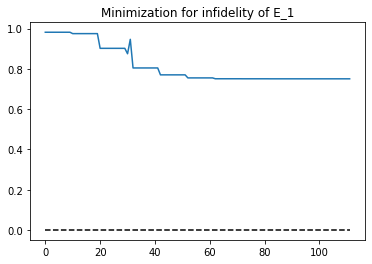

In [ ]:
plt.plot(np.array(E_data_vqe)[:,0],np.array(E_data_vqe)[:,1])
plt.title(f'Minimization for infidelity of E_{index}')
plt.hlines(0,0,E_data_vqe[-1][0],linestyles='dashed',color='black',label=f'E_{index} ED')

In [1090]:
print('fidelity=',1-result_inf.eigenvalue.real)

fidelity= 0.24924119314798965


In [1091]:
qinf.state_fidelity(Statevector(eigenvectors_matrix[:,1]),qinf.Statevector.from_instruction(result_inf.optimal_circuit.bind_parameters(result_inf.optimal_parameters.values()).to_instruction()))

0.24924119314813425

In [1092]:
fidelity_func(result,eigenvectors_matrix,num_eigs)

[0.9954160873396672,
 0.2492412291633147,
 0.49999999055867306,
 2.3145052192570552e-09]

##### Histograms

In [209]:
#action of E field
print(class_H_oprt.e_oper.to_matrix()@class_H_oprt.str_to_tens('00'),class_H_oprt.e_oper.to_matrix()@class_H_oprt.str_to_tens('01'),class_H_oprt.e_oper.to_matrix()@class_H_oprt.str_to_tens('11'))
print('vacuum E|01>=0|01>')
#action of charges
q10 = -0.5 * (class_H_oprt.I + class_H_oprt.Z).to_matrix()
q00 = 0.5 * (class_H_oprt.I - class_H_oprt.Z).to_matrix()

print(class_H_oprt.str_to_tens('0'),class_H_oprt.str_to_tens('1'))
print('even sites q - 0:', (q00@class_H_oprt.str_to_tens('0')).real,'q - 1:',(q00@class_H_oprt.str_to_tens('1')).real)
print('odd sites q - 0:',(q10@class_H_oprt.str_to_tens('0')).real,'q - 1:',(q10@class_H_oprt.str_to_tens('1')).real)

print('vacuum ..q2q1q0:1010')

[-1.+0.j  0.+0.j  0.+0.j  0.+0.j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j] [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
vacuum E|01>=0|01>
[1, 0] [0, 1]
even sites q - 0: [0. 0.] q - 1: [0. 1.]
odd sites q - 0: [-1.  0.] q - 1: [0. 0.]
vacuum ..q2q1q0:1010


In [210]:
def from_str_to_charges(str):
    """Return a string of particles configuration e+,e- or vacuum v
    Input a binary string of 0 and 1"""

    result = ''
    for i,q in enumerate(str):
        if i%2==0 and q=='0':
            result+='v'
        elif i%2==0 and q=='1':
            result+='e+'
        elif i%2==1 and q=='0':
            result+='e-'
        elif i%2==1 and q=='1':
            result+='v'
            
    return result



In [211]:
for s in {''.join(i) for i in permutations(['0','1']*(int(n_qubits_f)//2),int(n_qubits_f))}:
    print(s,from_str_to_charges(s)) 

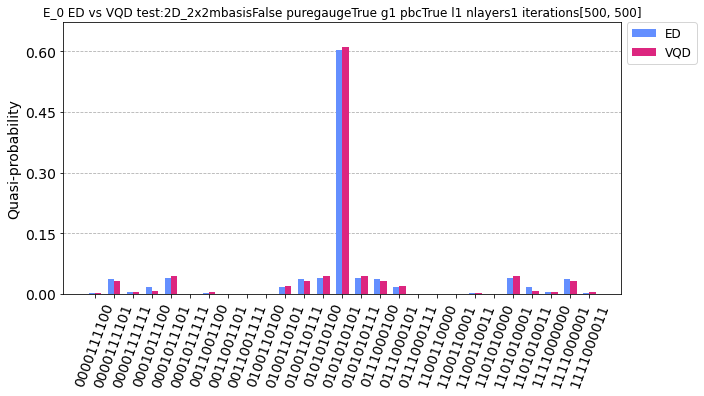

In [212]:
from qiskit.visualization import plot_histogram
plot_histogram([ed_val[0],vqd2_eigenstates[0]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_0 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')


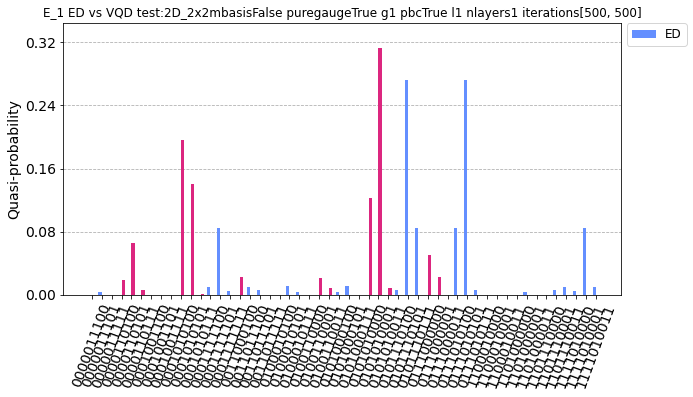

In [213]:
plot_histogram([ed_val[1],vqd2_eigenstates[1]], figsize=(10,5),legend=['ED','VQD'] ,bar_labels=False,
               title=f'E_1 ED vs VQD test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis} puregauge{puregauge} g{g} pbc{pbc} l{l} nlayers{nlayers} iterations{iterations}')
               #,filename='ansatz_tests/'+f'E_1_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}')

##### More coupling runs

In [ ]:
for g in np.array([1,1,1.01]):
    
    Hamiltonian_Pauli_tot = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)
    if encoding=='gray' and not sparse_pauli:
        Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
        if ngauge:
            h_b_sparse = class_H_oprt.hamiltonian_mag_pauli.to_matrix(sparse=True) #plaquette
        else:
            h_b_sparse = 0 
    elif encoding=='ed':
        Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)
        if ngauge:
            h_b_sparse =sp.csr_matrix(class_H_oprt.hamiltonian_mag_pauli)
        else:
            h_b_sparse =0
    spectrum, eigenvectors_matrix =primme.eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA")#,ncv = 30)
    #spectrum
    idx = spectrum.argsort() 
    spectrum = spectrum[idx]
    eigenvectors_matrix = eigenvectors_matrix[:,idx]

    eig0cj = sp.csr_matrix(eigenvectors_matrix[:,0]).transpose().conjugate()
    eig0= sp.csr_matrix(eigenvectors_matrix[:,0])
    if ngauge:
        plaq = (eig0*h_b_sparse*eig0cj/len(latt.plaq_list) ).toarray()[0][0].real

    print('spectrum ED:',spectrum,'plaq',plaq)
    
    #callback function
    E_data = [[] for k in range(num_eigs)]
    Fidelity = [[] for k in range(num_eigs)]
    def callback(eval_count, parameters, mean, meta, step):
        stdout.write("eig: %d/%d -> its %4d \r"%(step,num_eigs,eval_count)) # assuming SPSA
        stdout.flush()

        #fidelity
        vqd_states = [ansatz.bind_parameters(parameters) for i in range(num_eigs)]
        vqd_fid_states =[qinf.Statevector.from_instruction(i) for i in vqd_states]
        ed_fid_states =[Statevector(eigenvectors_matrix[:,i]) for i in range(num_eigs)]
        Fidelity[step-1].append([qinf.state_fidelity(vqd,ed) for vqd,ed in zip(vqd_fid_states,ed_fid_states)])

        #energy
        E_data[step-1].append([len(E_data[step-1]),mean,meta])
    Hamiltonian_Pauli_tot_vqd = class_H_oprt.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=0)


    iterations = [500 for i in range(num_eigs)]
    optimizer = [SLSQP(maxiter=itr) for itr in iterations] #SLSQP,COBYLA  #TODO: with NFT iSWAPS with also Rzz gates
    ansatz = qc_tot2
    betas = None#[2,]*(num_eigs-1)  #***default value computed as the mean square sum of the coefficients of the observable.

    #*** initial point
    val_init = np.pi/2
    #initial_point=[val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) for kkk in range(num_eigs)]
    initial_point=val_init*(2*np.random.rand(ansatz.num_parameters)-1.0) 

    #Perform VQD for Hamiltonian and plaquette operator
    vqd = VQD(estimator, fidelity, ansatz, optimizer, k=num_eigs, betas=betas,initial_point=initial_point,  callback=callback)
    result = vqd.compute_eigenvalues(operator = Hamiltonian_Pauli_tot_vqd,aux_operators = aux_operators)# Hamiltonian + auxiliary operator
    vqd_values = result.eigenvalues

    #eigenvectors
    vqd2_eigenstates = []
    for i in range(num_eigs):
        tmp = result.optimal_circuits[i].copy()
        
        tmp.measure_all()
        opt_pt =list(result.optimal_parameters[i].values())
        res = sampler.run(tmp, opt_pt).result() 
        
        vqd2_eigenstates.append({x:round(y,6) for x,y in res.quasi_dists[0].binary_probabilities().items() if y>0.0001})
        tmp.remove_final_measurements()

    if ngauge:
        plaq_vqd = np.array(result.aux_operators_evaluated[0])[:,0][0]/len(latt.plaq_list)

        print('g',g,'E',vqd_values)
        print('\n','Plaq. VQD:',plaq_vqd.real,'\n')

spectrum ED: [-1.0066823] plaq 0.4623451127700586
g 1.0 E [-0.96724394+0.j]

 Plaq. VQD: 0.46610870187127507 

spectrum ED: [-1.0066823] plaq 0.4623451127700586
g 1.0 E [-0.96724388+0.j]

 Plaq. VQD: 0.4660296628495903 

spectrum ED: [-0.95411825] plaq 0.45198162085604643
g 1.01 E [-0.91334138+0.j]

 Plaq. VQD: 0.45507543874845485 



### VARQITE

In [612]:
from qiskit_algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple

from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import VarQITE
#from qiskit.primitives import Estimator

In [678]:
var_principle = ImaginaryMcLachlanPrinciple()
time = 5.0
aux_ops = [Hamiltonian_Pauli_tot_vqd]

# estimator = Estimator()
# estimator.set_options(shots=2048,backend=backend)
print(estimator.options)
#not fastest method
# evolution_problem = TimeEvolutionProblem(Hamiltonian_Pauli_tot_vqd, time, aux_operators=aux_ops)
# var_qite = VarQITE(ansatz, initial_point, var_principle, Estimator())
# # an Estimator instance is necessary, if we want to calculate the expectation value of auxiliary operators.
# evolution_result = var_qite.evolve(evolution_problem)
#h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])

Options(shots=1024, backend=<IBMBackend('ibmq_qasm_simulator')>)


##### Efficient classical calculation of gradients with VarQITE

In [679]:
from qiskit_algorithms.gradients import ReverseEstimatorGradient, ReverseQGT
#fastest method
var_principle = ImaginaryMcLachlanPrinciple(qgt=ReverseQGT() , gradient=ReverseEstimatorGradient())
evolution_problem = TimeEvolutionProblem(Hamiltonian_Pauli_tot_vqd, time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, initial_point, var_principle, estimator)
evolution_result_eff = var_qite.evolve(evolution_problem)


In [ ]:
h_exp_val_eff = np.array([ele[0][0] for ele in evolution_result_eff.observables])
times = evolution_result_eff.times
gs_varqite = qinf.Statevector.from_instruction(evolution_result_eff.evolved_state)
plaq_varqite = (gs_varqite.expectation_value(class_H_oprt.hamiltonian_mag_pauli)/len(latt.plaq_list)).real

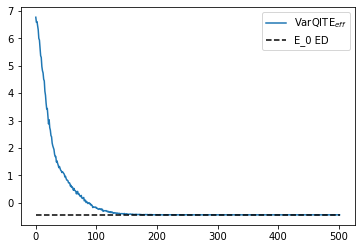

In [ ]:
plt.plot(h_exp_val_eff, label= r"VarQITE$_{eff}$")
plt.hlines(spectrum[0],0,len(times),linestyles='dashed',color='black',label=f'E_{0} ED')
plt.legend()

In [ ]:
varqite_H1 = Hamiltonian_Pauli_tot_vqd+2*SparsePauliOp.from_operator(gs_varqite.to_operator())
evolution_problem_e1 = TimeEvolutionProblem(varqite_H1, time, aux_operators=[varqite_H1])
var_qite_e1 = VarQITE(ansatz, initial_point, var_principle, estimator)
evolution_result_eff_e1 = var_qite_e1.evolve(evolution_problem_e1)

h_exp_val_eff_e1 = np.array([ele[0][0] for ele in evolution_result_eff_e1.observables])
times_e1 = evolution_result_eff_e1.times
gs_varqite_e1 = qinf.Statevector.from_instruction(evolution_result_eff_e1.evolved_state)

In [ ]:
#beta value is important to be low enough!

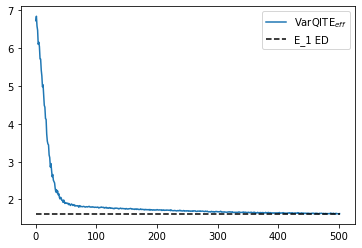

In [ ]:
plt.plot(h_exp_val_eff_e1, label= r"VarQITE$_{eff}$")
plt.hlines(spectrum[1],0,len(times_e1),linestyles='dashed',color='black',label=f'E_{1} ED')
plt.legend()

In [ ]:

print('Ground state energy E_0 err (VarQite-ED)',np.abs(h_exp_val_eff[-1]-spectrum[0]),'values:',h_exp_val_eff[-1],spectrum[0])
print('energy E_1 err (VarQite-ED)',np.abs(h_exp_val_eff_e1[-1]-spectrum[1]),'values:',h_exp_val_eff_e1[-1],spectrum[1])
print('plaq. <P> err (VarQite-ED)',np.abs(plaq_varqite-plaq))

print('Fidelity GS for VarQITE')
for i,en in enumerate([gs_varqite,gs_varqite_e1]):
    ed_fid_states =Statevector(eigenvectors_matrix[:,i]) 
    print(qinf.state_fidelity(en,ed_fid_states))

    varqite_eigs={x:round(y,6) for x,y in en.probabilities_dict().items() if y>0.0001}
    if ngauge:
        for varqite_res in [string[-(ngauge*n_qubits):][i:i+int(np.ceil(np.log2(2 * l+ 1)))] for string in varqite_eigs.keys() for i in range(0, len(string[-(ngauge*n_qubits):]), int(np.ceil(np.log2(2 * l+ 1))))]:
            if varqite_res in gray_unph:
                print('unphysical state reached for gauge fields')
                break
        else:   
            print(f'E_{i} all physical states reached gauge fields: OK!')
    if n_qubits_f:
        for varqite_res in [string[:n_qubits_f] for string in varqite_eigs.keys() ]:

            if varqite_res in ferm_q0:
                print('unphysical state reached for fermions')
                break
        else:   
            print(f'E_{i} all physical states reached fermions: OK!')

Ground state energy E_0 err (VarQite-ED) 5.454959604023202e-07 values: -0.4366923447933396 -0.43669289028930003
energy E_1 err (VarQite-ED) 0.00024148886241714962 values: 1.625778183815017 1.6255366949525998
plaq. <P> err (VarQite-ED) 6.7282889558151204e-06
Fidelity GS for VarQITE
0.9999999961078088
E_0 all physical states reached gauge fields: OK!
0.5210181893049102
E_1 all physical states reached gauge fields: OK!


In [587]:
#TODO: tentativo di usare la fidelity in vqd code per excited states for varqite
# step = 2
# batch_size = len(evolution_result_eff.parameter_values)
# total_cost = np.zeros(batch_size)
# sampler = Sampler()
# fidelity = ComputeUncompute(sampler)
# prev_states = []

# if step > 1:
#     prev_states.append(evolution_result_eff.evolved_state)
#     # compute overlap cost
#     batched_prev_states = [state for state in prev_states for _ in range(batch_size)]
#     fidelity_job = fidelity.run(
#         batch_size * [ansatz] * (step - 1),
#         batched_prev_states,
#         np.tile(evolution_result_eff.parameter_values, (step - 1, 1)),
#     )
#     costs = fidelity_job.result().fidelities

#     costs = np.reshape(costs, (step - 1, -1))
#     for state, cost in enumerate(costs):
#         total_cost += np.real(betas[state] * cost)